# Стохастический градиентный спуск (20 баллов)

In [ ]:
import os
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Optimizer

import torchvision
from torchvision.datasets.utils import download_url
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Основная часть (всего 10 баллов)

__Задача 1.__ В этой работе вы будете реализовывать стохастические методы на библиотеке torch. В основной части рассмотрим логистическую регрессию на [датасете](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a) из библиотеки LIBSVM.

__а) (1 балл)__ Реализуйте класс `LIBSVM` для работы с данными во время обучения/валидации. Допишите метод инициализации класса:
1. С помощью функции `load_svmlight_file` распарсите файл, лежащий в директории `file_dir`;
2. Преобразуйте дата-матрицу $X$ в формат `torch.Tensor` (воспользуйтесь функцией `torch.from_numpy`);
3. Выполните нормализацию данных по второй норме для каждой строки;
3. Преобразуйте вектор меток $y$ в формат `torch.Tensor`, а также приведите метки к значениям 0 и 1;
4. Разделите данные на обучающую и тестовую выборки, используя `train_test_split` с параметром `random_state=57`;
5. Преобразованные данные сохраните в атрибутах `self.train_dataset` и `self.test_dataset` как элементы класса `TensorDataset` (достаточно подать преобразованные тензоры $X$ и $y$ в него).

In [ ]:
DOWNLOAD_LINKS = {'a9a': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a'}

class LIBSVM(Dataset):
    def __init__(self, root, dataset_name, download=True, test_size=0.2, random_state=57):
        download_link = DOWNLOAD_LINKS[dataset_name]
        target = os.path.basename(download_link)
        file_dir = os.path.join(root, target)

        if not os.path.exists(file_dir):
            if download:
                download_url(download_link, root)
            else:
                raise FileNotFoundError(f"{file_dir} не существует")



        # YOUR CODE HERE

        X_csr, y_np= load_svmlight_file(file_dir)

        X_np= X_csr.toarray().astype(np.float32)
        X= torch.from_numpy(X_np)

        norms= torch.linalg.vector_norm(X, ord=2, dim=1, keepdim=True)
        X= X/torch.clamp(norms, min=1e-12)

        y_np= y_np.astype(np.int64)
        uniq= np.unique(y_np)
        if uniq.size==2:
            y_np = (y_np == uniq.max()).astype(np.int64)
        else:
            y_np = (y_np > 0).astype(np.int64)

        y = torch.from_numpy(y_np)

        idx = np.arange(X.shape[0])
        tr_idx, te_idx = train_test_split(idx, test_size=test_size,
                        random_state=random_state, shuffle=True, stratify=y_np)
        X_train, y_train= X[tr_idx], y[tr_idx]
        X_test, y_test= X[te_idx], y[te_idx]

        self.train_dataset= TensorDataset(X_train, y_train)
        self.test_dataset= TensorDataset(X_test, y_test)
        self.dataset= self.train_dataset




    def __getitem__(self, index):
        """
        Получение одного элемента из набора данных
        """
        return self.dataset.__getitem__(index)

    def __len__(self):
        """
        Количество элементов в наборе данных
        """
        return self.dataset.__len__()

In [ ]:
test = LIBSVM(root='.', dataset_name='a9a')

__б) (1 балл)__ Создайте модель `LogisticRegression`, которая будет представлять из себя [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html) без `bias` с функцией активации [`F.sigmoid`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html).

_Указание: необходимо выдавать одно значение — вероятность, что метка принадлежит 1 классу._

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):

        # YOUR CODE HERE

        super().__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1, bias=False)

    def forward(self, x):

        # YOUR CODE HERE

        logits = self.linear(x)
        prob = F.sigmoid(logits)
        res = prob.squeeze(-1)
        return res

__в) (2 балла)__ Рассмотрите стохастический градиентный спуск (SGD). Допишите код метода. В нем должна быть реализована возможность использовать моментум (параметр `momentum`), а также $L_2$-регуляризацию для каждого параметра (параметр `weight_decay`).

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $v^0 \in \mathbb{R}^d$
- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Моментумы $\{ \tau_k \}_{k=0} > 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$

---

$k$_-ая итерация_:

1. Вычислить градиент и применить $L_2$-регуляризацию:

$$
g^{k + 1} = \nabla f_i \left(x^k\right) + \lambda x^k
$$

2. Обновить буфер моментума:

$$
v^{k+1} = \tau_k v^{k} + g^{k+1}.
$$

3. Обновить параметры:

$$
x^{k+1} = x^k - \gamma_k v^{k+1}
$$

In [ ]:
class SGD(Optimizer):
    """
    Реализация стохастического градиентного спуска с моментумом и L2-регуляризацией.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        momentum (float): Коэффициент моментума
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, lr=1e-3, momentum=0, weight_decay=0):
        if lr < 0.0:
            raise ValueError(f"Неверный шаг: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Неверный моментум: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Неверный коэффициент L2-регуляризации: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super(SGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss
        """

        loss = closure() if closure is not None else None

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue


            # YOUR CODE HERE



            grad= p.grad.detach()

            if weight_decay!= 0:
                grad= grad.add(p.data, alpha=weight_decay)

            if momentum!= 0:
                state= self.state[p]
                buff= state.get('momentum_buffer')
                if buff is None:
                    buff= torch.zeros_like(p.data)
                    state['momentum_buffer']= buff
                buff.mul_(momentum).add_(grad)
                d_p=buff
            else:
                d_p=grad
            p.data.add_(d_p, alpha=-lr)

        return loss

__г) (2 балла)__ Реализуйте метод `trainer`, который принимает на вход все необходимые параметры для обучения и выполняет обучение и валидацию модели на протяжении заданного числа эпох. Допишите оберточные функции `train` и `test` для каждой эпохи обучения.

In [ ]:
def trainer(num_epochs, batch_size, model_class, criterion, optimizer_class,
            optimizer_params, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        dataset (Dataset): Объект датасета
        device (str): Устройство для вычислений

    Возвращает:
        tuple: (train_losses, train_accuracies, test_losses, test_accuracies)
            train_losses: значения потерь на обучении
            train_accuracies: значения accuracy на обучении
            test_losses: значения потерь на тесте
            test_accuracies: значения accuracy на тесте
    """
    # Инициализация DataLoader
    train_loader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Определение размерности входа
    input_dim = dataset.train_dataset[0][0].shape[0]

    # Инициализация модели
    model = model_class(input_dim=input_dim).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    # Метрики
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Функции для train/test одной эпохи
    def train_epoch(epoch):
        model.train()








        # YOUR CODE HERE

        running_loss= 0.0
        correct= 0
        total= 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out= model(x).view(-1)
            loss= criterion(out, y.float())

            loss.backward()
            optimizer.step()

            running_loss+= loss.item()*x.size(0)
            preds=out.round().long()
            correct+= (preds==y).sum().item()
            total+= y.size(0)

        train_loss = running_loss/total
        train_acc = (correct/total)*100.0
        return train_loss, train_acc






    def test_epoch(epoch):
        model.eval()



        # YOUR CODE HERE

        running_loss= 0.0
        correct= 0
        total= 0
        with torch.no_grad():
            for x, y in test_loader:
                out= model(x).view(-1)
                loss= criterion(out, y.float())

                running_loss+= loss.item()*x.size(0)
                preds=out.round().long()
                correct+= (preds==y).sum().item()
                total+= y.size(0)

        test_loss= running_loss/total
        test_acc= (correct/total)*100.0
        return test_loss, test_acc



    # Основной цикл обучения
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Вывод статистики
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1} / {num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | '
              f'Time: {epoch_time:.2f}s')

    return train_losses, train_accuracies, test_losses, test_accuracies

__д) (1 балл)__ Запустите обучение с предложенной ниже конфигурацией.

In [ ]:
config = {
    'num_epochs': 50,
    'batch_size': 120,
    'model_class': LogisticRegression,
    'criterion': nn.BCELoss(reduction='sum'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-6},
    'dataset': LIBSVM(root='./data', dataset_name='a9a'),
    'device' : 'cpu'
}

# Запуск обучения
train_loss, train_acc, test_loss, test_acc = trainer(**config)

Epoch 1 / 50 | Train Loss: 50.5584 | Train Acc: 80.47% | Test Loss: 44.7233 | Test Acc: 83.08% | Time: 0.41s
Epoch 2 / 50 | Train Loss: 42.6874 | Train Acc: 83.46% | Test Loss: 42.6849 | Test Acc: 83.85% | Time: 0.45s
Epoch 3 / 50 | Train Loss: 41.2271 | Train Acc: 83.92% | Test Loss: 41.7882 | Test Acc: 84.25% | Time: 0.61s
Epoch 4 / 50 | Train Loss: 40.4790 | Train Acc: 84.13% | Test Loss: 41.2930 | Test Acc: 84.37% | Time: 0.63s
Epoch 5 / 50 | Train Loss: 40.0629 | Train Acc: 84.23% | Test Loss: 40.9729 | Test Acc: 84.54% | Time: 0.58s
Epoch 6 / 50 | Train Loss: 39.7691 | Train Acc: 84.23% | Test Loss: 40.8674 | Test Acc: 84.31% | Time: 0.66s
Epoch 7 / 50 | Train Loss: 39.6003 | Train Acc: 84.32% | Test Loss: 40.5922 | Test Acc: 84.54% | Time: 0.44s
Epoch 8 / 50 | Train Loss: 39.4211 | Train Acc: 84.42% | Test Loss: 40.4700 | Test Acc: 84.52% | Time: 0.43s
Epoch 9 / 50 | Train Loss: 39.3117 | Train Acc: 84.42% | Test Loss: 40.3858 | Test Acc: 84.58% | Time: 0.41s
Epoch 10 / 50 | Tra

Постройте сравнительные графики значений функции потерь и значений метрики `accuracy` в зависимости от числа эпох.

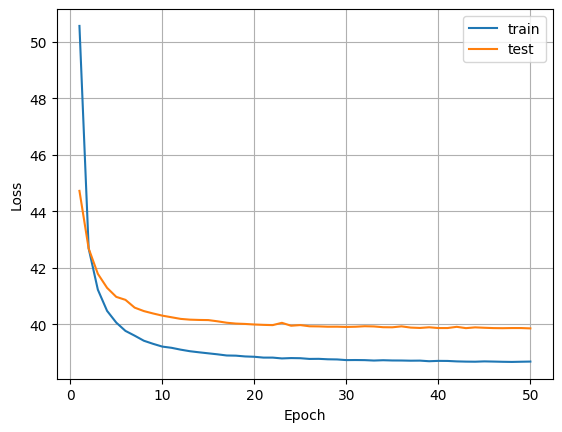

In [ ]:
# Ваше решение (Code)

epochs = range(1,51)

plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, test_loss,  label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

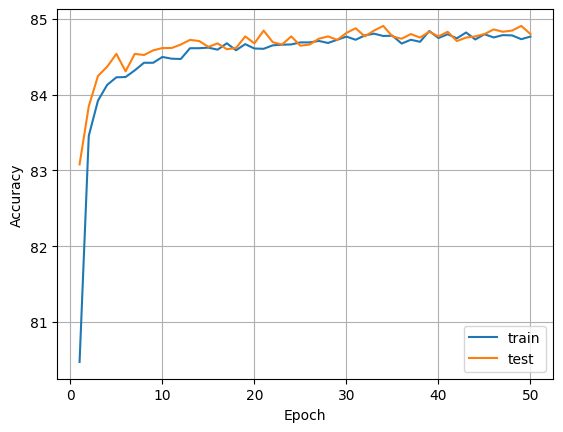

In [ ]:
plt.plot(epochs, train_acc,label='train')
plt.plot(epochs, test_acc,label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

__Задача 2.__ В предыдущей задаче мы убедились, что даже простая модель быстро достигает высокой точности на табличных данных — достаточно одной эпохи для получения высокого значения метрики. Однако в реальных задачах, данные сложнее, и выбор гиперпараметров играет важную роль. В этом задании мы посмотрим, как размер батча влияет на качество обучения и скорость сходимости модели на примере датасета [`FashionMNIST`](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, root='.', download=True):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.train_dataset = torchvision.datasets.FashionMNIST(
            root=root, train=True, download=download, transform=transform)
        self.test_dataset = torchvision.datasets.FashionMNIST(
            root=root, train=False, download=download, transform=transform)

    def __getitem__(self, index):
        """
        Получение одного элемента из набора данных
        """
        return self.dataset.__getitem__(index)

    def __len__(self):
        """
        Количество элементов в наборе данных
        """
        return self.dataset.__len__()

In [ ]:
FashionMNIST_dataset = FashionMNIST(root='.')

In [ ]:
fashion_classes = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
)

def imshow_fashionmnist(img, ax=None, title=None):
    npimg = img.numpy().squeeze()  # (1, H, W) → (H, W)
    if ax is None:
        plt.imshow(npimg, cmap='gray')
        if title:
            plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(npimg, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

def show_fashionmnist_samples(dataset, num_samples=20, rows=4, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        imshow_fashionmnist(image, ax=ax, title=fashion_classes[label])

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Amount of train samples: 60000
Amount of test samples: 10000


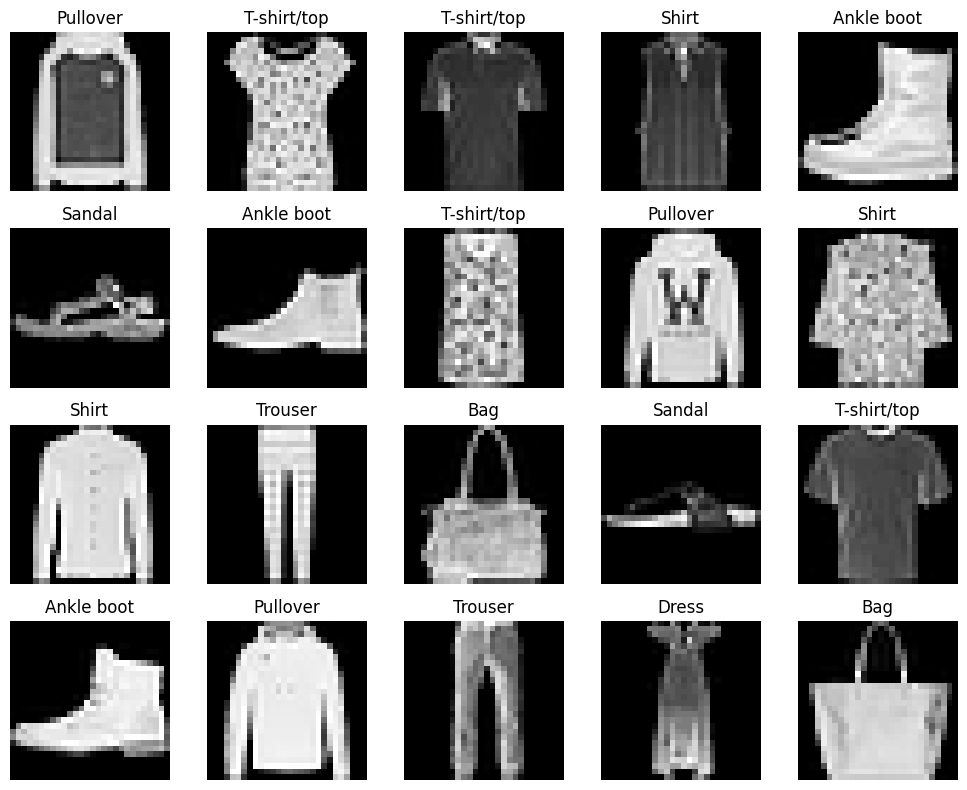

In [ ]:
print(f"Amount of train samples: {len(FashionMNIST_dataset.train_dataset)}")
print(f"Amount of test samples: {len(FashionMNIST_dataset.test_dataset)}")

show_fashionmnist_samples(FashionMNIST_dataset.train_dataset)

__а) (1 балл)__ Рассмотрим более глубокую нейронную сеть, так как логистическая регрессия недостаточно хорошо приближает распределение данных в датасете F-MNIST. Реализуйте Multi-Layerd Perceptron (MLP), считая известным, что F-MNIST состоит из картинок размера 28*28, а число классов в нем равно 10:
1. [nn.Flatten()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
2. [nn.Linear(input_size, hidden_size)](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
3. [nn.ReLU()](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
4. [nn.Linear(hidden_size, num_classes)](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, num_classes=10):

        # YOUR CODE HERE

        super().__init__()
        self.flatten= nn.Flatten()
        self.fc1= nn.Linear(input_size, hidden_size)
        self.relu= nn.ReLU()
        self.fc2= nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        # YOUR CODE HERE

        x= self.flatten(x)
        x= self.fc1(x)
        x= self.relu(x)
        x= self.fc2(x)
        return x

__б) (1 балл)__ Модифицируйте метод `trainer`, добавив поддержку многоклассовой классификации.

In [ ]:
def trainer(num_epochs, batch_size, model_class, criterion, optimizer_class,
            optimizer_params, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):

    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        dataset (Dataset): Объект датасета
        device (str): Устройство для вычислений

    Возвращает:
        tuple: (train_losses, train_accuracies, test_losses, test_accuracies)
            train_losses: значения потерь на обучении
            train_accuracies: значения accuracy на обучении
            test_losses: значения потерь на тесте
            test_accuracies: значения accuracy на тесте
    """
    # Инициализация DataLoader
    train_loader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Инициализация модели
    model = model_class().to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    # Метрики
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Функции для train/test одной эпохи
    def train_epoch(epoch):
        model.train()



        # YOUR CODE HERE

        running_loss= 0.0
        correct= 0
        total= 0

        for x, y in train_loader:
          x= x.to(device)
          y= y.to(device)

          optimizer.zero_grad()
          out= model(x)

          if out.dim()>1 and out.size(-1) > 1:
              loss= criterion(out, y.long())
              preds= out.argmax(dim=1)
          else:
              out= out.view(-1)
              loss= criterion(out, y.float())
              preds= out.round().long()

          loss.backward()
          optimizer.step()

          running_loss+= loss.item()*x.size(0)
          correct+=(preds==y).sum().item()
          total+= y.size(0)

        train_loss = running_loss/total
        train_acc = (correct / total)*100.0




        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()

        # YOUR CODE HERE
        running_loss= 0.0
        correct= 0
        total= 0
        with torch.no_grad():
            for x, y in test_loader:
                x= x.to(device)
                y= y.to(device)

                out= model(x)

                if out.dim()>1 and out.size(-1)>1:
                    loss= criterion(out, y.long())
                    preds= out.argmax(dim=1)
                else:
                    out= out.view(-1)
                    loss= criterion(out, y.float())
                    preds= out.round().long()

                running_loss+= loss.item()*x.size(0)
                correct+= (preds==y).sum().item()
                total+= y.size(0)

        test_loss = running_loss/total
        test_acc = (correct / total)*100.0


        return test_loss, test_acc

    # Основной цикл обучения
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Сохранение метрик
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Вывод статистики
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1} / {num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | '
              f'Time: {epoch_time:.2f}s')

    return train_losses, train_accuracies, test_losses, test_accuracies

__в) (1 балл)__ Исследуйте влияние размера батча на качество модели. Используя предоставленный шаблон, постройте сравнительные графики значений функции потерь и значений метрики `accuracy` в зависимости от размера батча.


=== Training with batch size: 32 ===
Epoch 1 / 3 | Train Loss: 72.6257 | Train Acc: 17.08% | Test Loss: 72.5505 | Test Acc: 19.56% | Time: 11.51s
Epoch 2 / 3 | Train Loss: 72.6227 | Train Acc: 17.29% | Test Loss: 72.5960 | Test Acc: 17.98% | Time: 12.39s
Epoch 3 / 3 | Train Loss: 72.6318 | Train Acc: 17.51% | Test Loss: 72.5655 | Test Acc: 18.35% | Time: 11.35s

=== Training with batch size: 64 ===
Epoch 1 / 3 | Train Loss: 148.2441 | Train Acc: 7.48% | Test Loss: 148.0746 | Test Acc: 7.27% | Time: 9.55s
Epoch 2 / 3 | Train Loss: 148.2523 | Train Acc: 8.67% | Test Loss: 148.1382 | Test Acc: 7.45% | Time: 9.67s
Epoch 3 / 3 | Train Loss: 148.2429 | Train Acc: 7.80% | Test Loss: 148.0919 | Test Acc: 8.46% | Time: 10.51s

=== Training with batch size: 128 ===
Epoch 1 / 3 | Train Loss: 294.9125 | Train Acc: 10.18% | Test Loss: 294.5887 | Test Acc: 8.11% | Time: 9.19s
Epoch 2 / 3 | Train Loss: 294.9411 | Train Acc: 9.59% | Test Loss: 294.4158 | Test Acc: 11.02% | Time: 9.29s
Epoch 3 / 3 | T

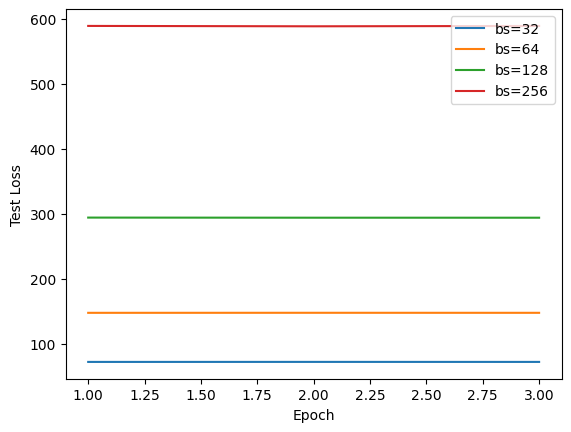

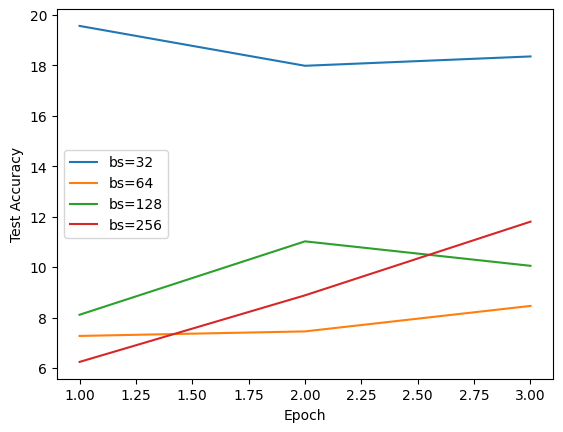

In [ ]:
batch_sizes = [32, 64, 128, 256]

base_lr = 1e-3

train_acc_list=[]
test_acc_list=[]

for batch_size in batch_sizes:
    print(f"\n=== Training with batch size: {batch_size} ===")
    config = {
        'num_epochs': 3, #Очень долго, было 10..
        'model_class': MLP,
        'criterion': nn.CrossEntropyLoss(reduction='sum'),
        'optimizer_class': SGD,
        'optimizer_params': {
            'lr': base_lr * np.sqrt(batch_size / 32),
            'momentum': 0.8,
            'weight_decay': 1e-4,
        },
        'dataset': FashionMNIST(),
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'batch_size': batch_size
    }

    train_loss, train_acc, test_loss, test_acc = trainer(**config)

    # YOUR CODE HERE


    train_acc_list.append(float(train_acc[-1]))
    test_acc_list.append(float(test_acc[-1]))

    epochs = range(1, len(test_acc) + 1)

    plt.figure(1)
    plt.plot(epochs, test_loss, label=f'bs={batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.grid()
    plt.legend()

    plt.figure(2)
    plt.plot(epochs, test_acc, label=f'bs={batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.legend()

In [ ]:
# Ваше решение (Code)

## Дополнительная часть (10 баллов)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from torch import optim
from torchvision.models import resnet18

__Задача 2.__ В данной части будут рассмотрены не столь "игрушечные" датасеты, а уже проверенный временем бенчмарк для компьютерного зрения — связка из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (картинки 32 $\times$ 32, 50,000 сэмплов train, 10,000 сэмплов test, 10 классов) и нейронной архитектуры [ResNet18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html). Так как курс посвящен оптимизации, то предлагается импортировать саму архитектуру (без непосредственной реализации) и работать с ней в парадигме "black-box" оптимизации — дан черный ящик в виде модели, хотим достичь наилучшего качества обучения.

In [ ]:
class CIFAR10(Dataset):
    def __init__(self, root, download=True, normalize_mean=(0.5, 0.5, 0.5), normalize_std=(0.5, 0.5, 0.5)):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std)
        ])

        self.train_dataset = torchvision.datasets.CIFAR10(
            root = '.',
            train = True,
            transform = transform,
            download = download,
        )
        self.test_dataset = torchvision.datasets.CIFAR10(
            root = '.',
            train = False,
            transform = transform,
            download = download,
        )

    def __getitem__(self, index):
        """
        Получение одного элемента из набора данных
        """
        return self.dataset.__getitem__(index)

    def __len__(self):
        """
        Количество элементов в наборе данных
        """
        return self.dataset.__len__()

In [ ]:
CIFAR10_dataset = CIFAR10(root='.')

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ax=None, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            ax.set_title(title)
        ax.axis('off')


def show_dataset_samples(dataset, num_samples=20, rows=4, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for i, ax in enumerate(zip(indices, axes)):
        image, label = dataset[i]
        imshow(image, ax=ax[1], title=classes[label])

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Amount of train samples: 50000
Amount of test samples: 10000


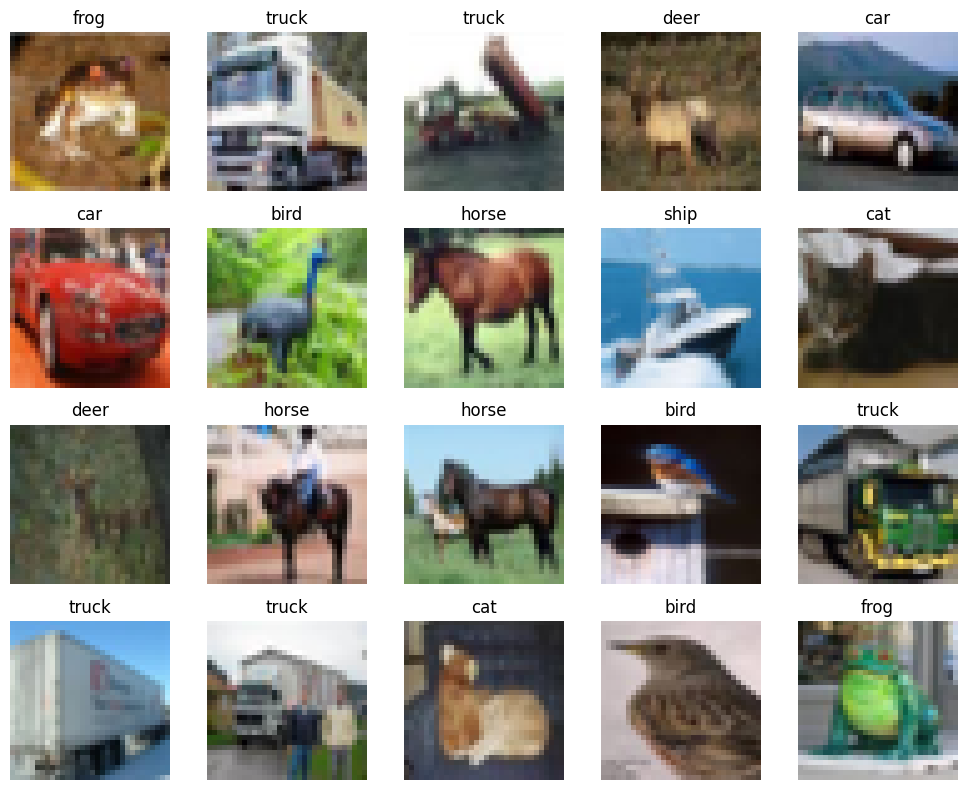

In [ ]:
print(f"Amount of train samples: {len(CIFAR10_dataset.train_dataset)}")
print(f"Amount of test samples: {len(CIFAR10_dataset.test_dataset)}")

show_dataset_samples(CIFAR10_dataset.train_dataset)

Теперь проинициализируем сверточную модель `ResNet18` ([оригинальная статья](https://arxiv.org/abs/1512.03385), [реализация в torch](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)), для желающих разобраться, из каких слоев она состоит, добавлена функция `print_model_summary`, в которой перечислены все слои и число обучаемых параметров.

In [ ]:
# Число классов в датасете - 10
resnet = resnet18(weights=None, num_classes=10)

In [ ]:
def print_model_summary(model, input_size):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = f"{class_name}-{module_idx+1}"
            summary[m_key] = {
                "input_shape": list(input[0].size()),
                "output_shape": list(output.size()),
                "nb_params": sum(p.numel() for p in module.parameters())
            }

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and module != model:
            hooks.append(module.register_forward_hook(hook))

    summary = {}
    hooks = []

    model.apply(register_hook)

    model.eval()
    with torch.no_grad():
        model(torch.zeros(1, *input_size))

    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")

    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")

    total_params = 0

    for layer in summary:
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"])
        )

        total_params += summary[layer]["nb_params"]

        print(line_new)

    print("================================================================")
    print(f"Total params: {total_params:,}")
    print("----------------------------------------------------------------")

# Входной размер картинки - (3, 32, 32), так как она RGB-шная
print_model_summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 16, 16]           9,408
       BatchNorm2d-2            [1, 64, 16, 16]             128
              ReLU-3            [1, 64, 16, 16]               0
         MaxPool2d-4              [1, 64, 8, 8]               0
            Conv2d-5              [1, 64, 8, 8]          36,864
       BatchNorm2d-6              [1, 64, 8, 8]             128
              ReLU-7              [1, 64, 8, 8]               0
            Conv2d-8              [1, 64, 8, 8]          36,864
       BatchNorm2d-9              [1, 64, 8, 8]             128
             ReLU-10              [1, 64, 8, 8]               0
       BasicBlock-11              [1, 64, 8, 8]          73,984
           Conv2d-12              [1, 64, 8, 8]          36,864
      BatchNorm2d-13              [1, 64, 8, 8]             128
             ReLU-14              [1, 6

__a) (5 баллов)__ Рассмотрите несколько типов `lr_scheduler` — планировщика скорости обучения, предоставлямых библиотекой `torch`:

1) [`LambdaLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html)

$$
lr_{epoch + 1} = lr_{base} \cdot \lambda(epoch + 1)
$$

2) [`ExponentialLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)

$$
lr_{epoch + 1} = \gamma \cdot lr_{epoch}
$$

3) [`ReduceLRonPlateu`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)

    Шаг уменьшается на фактор при достижении плато в функции ошибок.

4) [`CosineAnnealingLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)

$$
lr_{epoch + 1} = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})
    \left(1 + \cos \left(\frac{\pi (epoch + 1)}{T_{\max}}\right)\right)
$$

5) [`LinearLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html)

$$
lr_{epoch + 1} = lr_{base} \cdot \left(\alpha + \left(1 - \alpha \right) \left(1 - \frac{epoch + 1}{T_{\max}}\right) \right)
$$

Для удобства дальнейшего использования предлагается функция `get_lr_schedule`.

In [ ]:
def get_lr_schedule(model_class, optimizer_class, optimizer_params, scheduler_class, scheduler_params,
                    num_epochs=100, dummy_loss=None):
    """
    Возвращает список значений learning rate для заданного планировщика.

    Параметры:
        model_class (nn.Module): Модель
        optimizer_class (optim.Optimizer): Оптимизатор
        optimizer_params (dict): Параметры оптимизатора
        scheduler_class (optim.lr_scheduler): Планировщик скорости обучения
        scheduler_params (dict): Параметры планировщика
        num_epochs (int): Количество эпох для симуляции
        dummy_loss (list or None): Список значений потерь для ReduceLROnPlateau

    Возвращает:
        lrs (list): Список learning rate на каждой итерации
    """

    model = model_class()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    scheduler = scheduler_class(optimizer, **scheduler_params)

    lrs = []

    for i in range(num_epochs):
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            loss = dummy_loss[i] if dummy_loss is not None else 1.0
            scheduler.step(loss)
        else:
            scheduler.step()

        lrs.append(optimizer.param_groups[0]['lr'])

    return lrs

Изобразите поведение от номера эпохи `lr_scheduler`: `ExponentialLR`, `ReduceLRonPlateu`, `CosineAnnealingLR`, `LinearLR` (используйте готовые реализации в `torch`).

In [ ]:
# Простая модель
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 2)

    def forward(self, x):
        return self.linear(x)

In [ ]:
num_epochs = 100
dummy_losses = [1.0 / (i + 1) for i in range(num_epochs - 30)] + [0.0001 for j in range(30)]

lr_exponential = get_lr_schedule(DummyModel, optim.SGD, {'lr': 0.1},
                                optim.lr_scheduler.ExponentialLR, {'gamma': 0.95},
                                num_epochs=num_epochs)

lr_plateau = get_lr_schedule(DummyModel, optim.SGD, {'lr': 0.1},
                            optim.lr_scheduler.ReduceLROnPlateau, {'factor': 0.5, 'patience': 5},
                            num_epochs=num_epochs, dummy_loss=dummy_losses)

lr_cosine = get_lr_schedule(DummyModel, optim.SGD, {'lr': 0.1},
                           optim.lr_scheduler.CosineAnnealingLR, {'T_max': num_epochs},
                           num_epochs=num_epochs)

lr_linear = get_lr_schedule(DummyModel, optim.SGD, {'lr': 0.1},
                           optim.lr_scheduler.LinearLR, {'start_factor': 1.0, 'end_factor': 0.0,
                                                         'total_iters': num_epochs},
                           num_epochs=num_epochs)

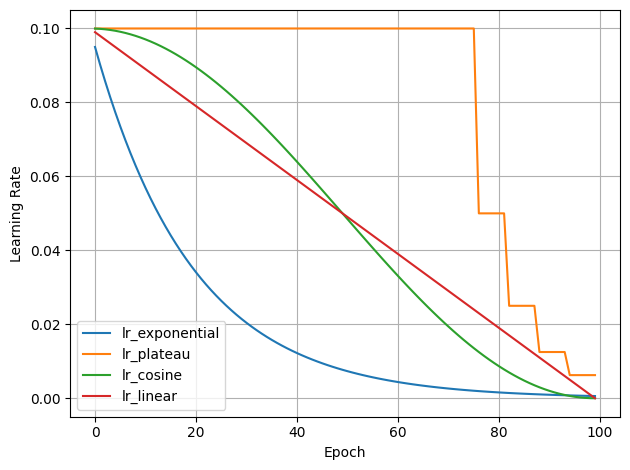

In [ ]:
# Визуализация
plt.plot(lr_exponential, label="lr_exponential")
plt.plot(lr_plateau, label="lr_plateau")
plt.plot(lr_cosine, label="lr_cosine")
plt.plot(lr_linear, label="lr_linear")

plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Теперь применим соответсвующие скедулеры для связки `CIFAR10` + `ResNet18`. Дополните функцию `trainer` с обновлением шага раз в эпоху. Добавьте возможность использования скедулера/шедулера (`torch.optim.lr_scheduler`), а также убрав значения входных размерностей, так как они известны. В качестве оптимизатора используйте написанный класс `SGD` с параметром моментума равным 0.8. Постройте сравнительные графики функции ошибок и значений метрики для каждого скедулера. Какой скедулер показал себя лучше всего?

In [ ]:
def trainer(num_epochs, batch_size, model_class, criterion, optimizer_class=SGD, optimizer_params=None,
            scheduler_class=None, scheduler_params=None, dataset=None,
            device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        scheduler_class (optim.lr_scheduler): Класс планировщика скорости обучения
        scheduler_params (dict): Параметры планировщика скорости обучения
        dataset (Dataset): Объект датасета
        device (str): Устройство для вычислений

    Возвращает:
        model (nn.Module): Обученная модель
        metrics (dict): Словарь с логами
    """

    # Создаем загрузчики данных
    train_loader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Инициализируем модель, оптимизатор
    model = model_class.to(device)
    optimizer = optimizer_class(model.parameters(), **(optimizer_params or {}))

    # Инициализируем планировщик
    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **(scheduler_params or {}))

    # Метрики
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []
    }

    def train_epoch(epoch):
        model.train()

        # YOUR CODE HERE


        running_loss= 0.0
        correct= 0
        total= 0
        red = getattr(criterion, 'reduction', 'mean')

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)

            if out.dim()>1 and out.size(-1)>1:
                loss= criterion(out, y.long())
                preds= out.argmax(dim=1)
            else:
                out= out.view(-1)
                loss= criterion(out, y.float())
                preds= out.round().long()

            loss.backward()
            optimizer.step()

            bs=y.size(0)
            running_loss+= loss.item()*(bs if red!= 'sum' else 1)
            correct+= (preds == y).sum().item()
            total+= bs

        train_loss= running_loss/total
        train_acc= (correct/total)*100.0







        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()





        # YOUR CODE HERE

        running_loss, correct, total = 0.0, 0, 0
        red = getattr(criterion, 'reduction', 'mean')

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)

                out = model(x)
                if out.dim() > 1 and out.size(-1) > 1:
                    loss = criterion(out, y.long())
                    preds = out.argmax(dim=1)
                else:
                    out = out.view(-1)
                    loss = criterion(out, y.float())
                    preds= out.round().long()

                bs= y.size(0)
                running_loss+= loss.item()*(bs if red!= 'sum' else 1)
                correct+= (preds==y).sum().item()
                total+= bs

        test_loss= running_loss / total
        test_acc= (correct/total)*100.0





        return test_loss, test_acc

    # Обучение
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Шаг планировщика

        # YOUR CODE HERE

        if scheduler is not None:
          if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            scheduler.step(test_loss)
          else:
            scheduler.step()

        # Сохраняем метрики
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)
        metrics["learning_rates"].append(optimizer.param_groups[0]['lr'])

        # Логирование
        elapsed = time.time() - start_time
        print(f"Epoch {epoch + 1} / {num_epochs} | "
              f"LR: {metrics['learning_rates'][-1]:.2e} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
              f"Time: {elapsed:.2f}s")

    # Возвращаем модель и метрики
    return model, metrics

Посмотрим на работу одного `lr_scheduler`. Используйте его как пример в построении графиков.

In [ ]:
resnet = resnet18(weights=None, num_classes=10)

config = {
    'num_epochs': 3, #Уменьшил, было долго..
    'batch_size': 128,
    'model_class': resnet,
    'criterion': nn.CrossEntropyLoss(reduction='mean'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
    'scheduler_class': optim.lr_scheduler.CosineAnnealingLR,
    'scheduler_params': {'T_max': 10, 'eta_min': 0.001},
    'dataset': CIFAR10_dataset,
    'device' : 'cuda',
}

# Запуск обучения
trained_resnet, metrics = trainer(**config)

Epoch 1 / 3 | LR: 9.78e-03 | Train Loss: 2.4606, Train Acc: 10.36% | Test Loss: 2.4514, Test Acc: 10.53% | Time: 30.99s
Epoch 2 / 3 | LR: 9.14e-03 | Train Loss: 2.4407, Train Acc: 10.58% | Test Loss: 2.4565, Test Acc: 10.45% | Time: 32.99s
Epoch 3 / 3 | LR: 8.15e-03 | Train Loss: 2.4408, Train Acc: 10.61% | Test Loss: 2.4526, Test Acc: 10.32% | Time: 32.57s


Используя следующие параметры, постройте сравнительные графики функции ошибок и значений метрики для каждого `lr_scheduler`.

In [ ]:
schedulers = {
    'CosineAnnealingLR': (optim.lr_scheduler.CosineAnnealingLR, {'T_max': 10, 'eta_min': 0.001}),
    'ExponentialLR': (optim.lr_scheduler.ExponentialLR, {'gamma': 0.9}),
    'ReduceLROnPlateau': (optim.lr_scheduler.ReduceLROnPlateau, {'mode': 'min', 'factor': 0.5, 'patience': 2}),
    'LinearLR': (optim.lr_scheduler.LinearLR, {'start_factor': 0.1, 'end_factor': 1.0, 'total_iters': 10}),
}

# YOUR CODE HERE

metrics_by_scheduler = {}

for name, (sched_cls, sched_params) in schedulers.items():
    config = {
        'num_epochs': 10, 'batch_size': 128,
        'model_class': resnet18(weights=None, num_classes=10),
        'criterion': nn.CrossEntropyLoss(reduction='mean'),
        'optimizer_class': SGD,
        'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
        'scheduler_class': sched_cls, 'scheduler_params': sched_params,
        'dataset': CIFAR10_dataset, 'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    }
    trs, m = trainer(**config)
    metrics_by_scheduler[name] = m

Epoch 1 / 10 | LR: 9.78e-03 | Train Loss: 2.5112, Train Acc: 9.15% | Test Loss: 2.4934, Test Acc: 8.77% | Time: 32.00s
Epoch 2 / 10 | LR: 9.14e-03 | Train Loss: 2.4877, Train Acc: 9.04% | Test Loss: 2.4912, Test Acc: 8.71% | Time: 31.85s
Epoch 3 / 10 | LR: 8.15e-03 | Train Loss: 2.4881, Train Acc: 9.18% | Test Loss: 2.4929, Test Acc: 8.77% | Time: 31.34s
Epoch 4 / 10 | LR: 6.89e-03 | Train Loss: 2.4871, Train Acc: 9.17% | Test Loss: 2.4928, Test Acc: 8.56% | Time: 30.89s
Epoch 5 / 10 | LR: 5.50e-03 | Train Loss: 2.4868, Train Acc: 9.13% | Test Loss: 2.4906, Test Acc: 8.85% | Time: 31.47s
Epoch 6 / 10 | LR: 4.11e-03 | Train Loss: 2.4872, Train Acc: 9.32% | Test Loss: 2.4944, Test Acc: 8.69% | Time: 30.89s
Epoch 7 / 10 | LR: 2.85e-03 | Train Loss: 2.4878, Train Acc: 9.29% | Test Loss: 2.4917, Test Acc: 8.68% | Time: 31.72s
Epoch 8 / 10 | LR: 1.86e-03 | Train Loss: 2.4878, Train Acc: 9.07% | Test Loss: 2.4899, Test Acc: 8.82% | Time: 31.02s
Epoch 9 / 10 | LR: 1.22e-03 | Train Loss: 2.4863

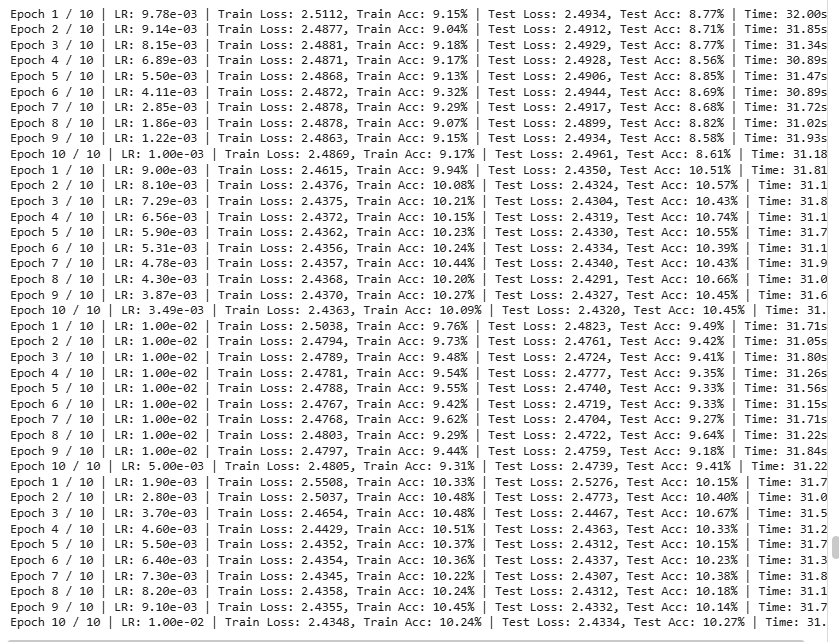

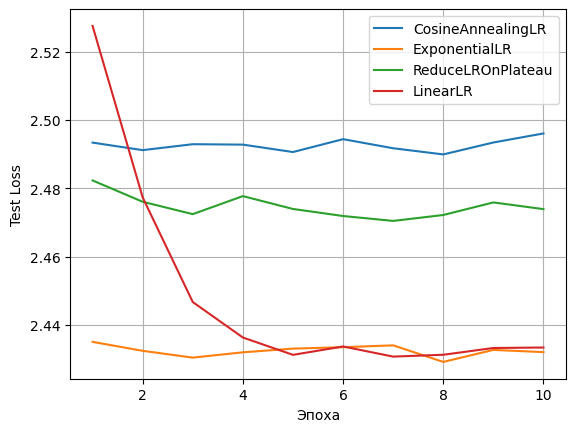

In [ ]:
# Ваше решение (Code)
for name, m in metrics_by_scheduler.items():
    epochs = range(1, len(m['test_loss']) + 1)
    plt.plot(epochs, m['test_loss'], label=name)
plt.xlabel('Эпоха')
plt.ylabel('Test Loss')
plt.grid()
plt.legend()
plt.show()

Я еле дождался пока пройдут 10 эпох, так что бэкап:

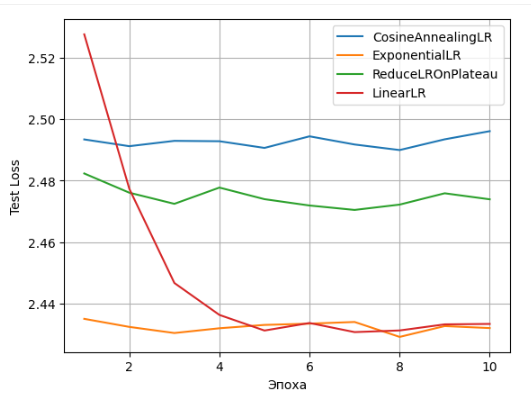

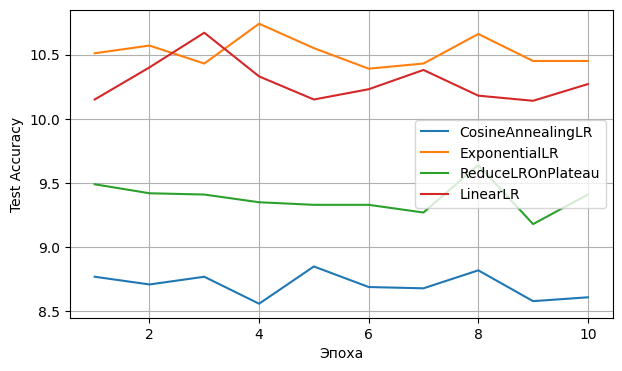

In [ ]:
plt.figure(figsize=(7,4))
for name, m in metrics_by_scheduler.items():
    epochs = range(1, len(m['test_acc']) + 1)
    plt.plot(epochs, m['test_acc'], label=name)
plt.xlabel('Эпоха')
plt.ylabel('Test Accuracy')
plt.grid()
plt.legend()
plt.show()

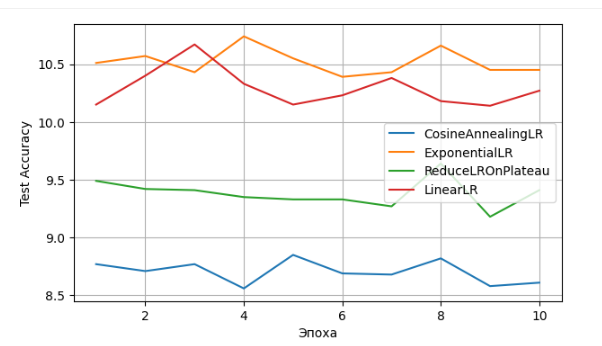

Какой `lr_scheduler` показал себя лучше всего?

In [ ]:
# Ваше решение (Markdown)

**Ответ:** exponentialLR, LinearLR тоже неплохо, но долго разгонялся и всё ещё немного хуже

Посмотрим, чему научилась наша модель на картинках из тестового датасета. Возьмите для этого модель, которая достигла лучших показателей на тестовом датасете и передайте как параметр в предложенной функции визуализации.

In [ ]:
resnet = resnet18(weights=None, num_classes=10)

config = {
    'num_epochs': 10,
    'batch_size': 128,
    'model_class': resnet,
    'criterion': nn.CrossEntropyLoss(reduction='mean'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
    'scheduler_class': optim.lr_scheduler.ExponentialLR,
    'scheduler_params': {'gamma': 0.9},
    'dataset': CIFAR10_dataset,
    'device' : 'cuda',
}

trained_resnet, metrics = trainer(**config)

Epoch 1 / 10 | LR: 9.00e-03 | Train Loss: 2.4654, Train Acc: 10.27% | Test Loss: 2.4459, Test Acc: 9.93% | Time: 31.23s
Epoch 2 / 10 | LR: 8.10e-03 | Train Loss: 2.4530, Train Acc: 10.13% | Test Loss: 2.4439, Test Acc: 9.98% | Time: 31.25s
Epoch 3 / 10 | LR: 7.29e-03 | Train Loss: 2.4518, Train Acc: 9.94% | Test Loss: 2.4491, Test Acc: 9.94% | Time: 31.13s
Epoch 4 / 10 | LR: 6.56e-03 | Train Loss: 2.4529, Train Acc: 10.03% | Test Loss: 2.4472, Test Acc: 9.87% | Time: 31.33s
Epoch 5 / 10 | LR: 5.90e-03 | Train Loss: 2.4511, Train Acc: 9.82% | Test Loss: 2.4483, Test Acc: 9.84% | Time: 31.14s
Epoch 6 / 10 | LR: 5.31e-03 | Train Loss: 2.4508, Train Acc: 9.99% | Test Loss: 2.4465, Test Acc: 9.79% | Time: 31.63s
Epoch 7 / 10 | LR: 4.78e-03 | Train Loss: 2.4533, Train Acc: 9.92% | Test Loss: 2.4464, Test Acc: 9.82% | Time: 31.18s
Epoch 8 / 10 | LR: 4.30e-03 | Train Loss: 2.4496, Train Acc: 9.91% | Test Loss: 2.4454, Test Acc: 9.91% | Time: 31.67s
Epoch 9 / 10 | LR: 3.87e-03 | Train Loss: 2.4

In [ ]:
def show_model_predictions(model, dataset, num_samples=20, rows=4, cols=5, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for i, ax in enumerate(zip(indices, axes)):
        image, label = dataset[i]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)

        imshow(image, ax=ax[1], title=f"True: {classes[label]}\nPred: {classes[predicted.item()]}")

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

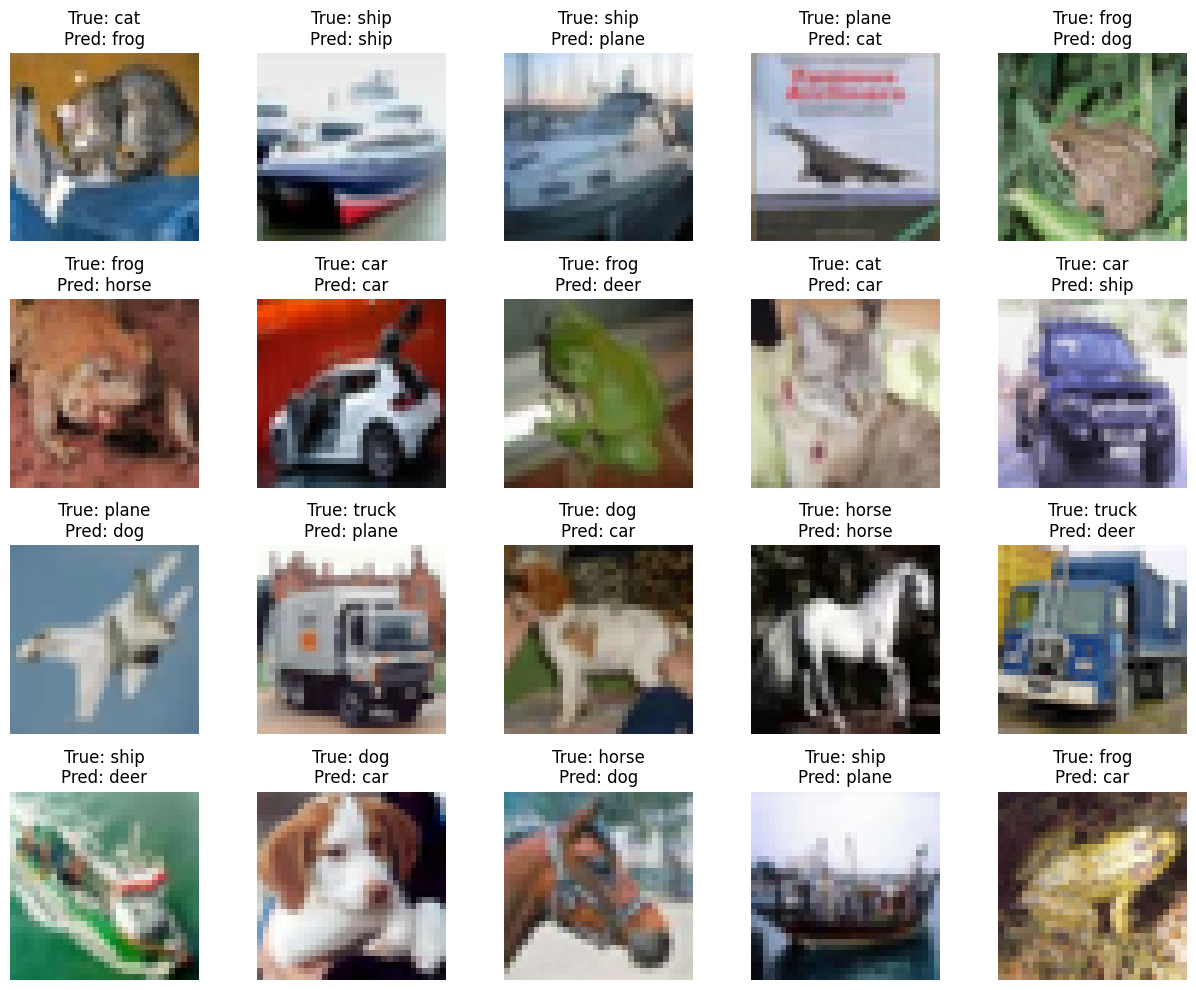

In [ ]:
show_model_predictions(
    trained_resnet,
    CIFAR10_dataset.test_dataset,
    num_samples=20,
    rows=4,
    cols=5,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

__б) (5 баллов)__ Реализуйте две [техники](https://proceedings.neurips.cc/paper_files/paper/2020/file/c8cc6e90ccbff44c9cee23611711cdc4-Paper.pdf) перемешивания (shuffling-а), а именно: __RandomReshuffling__ и __ShuffleOnce__. Данные техники позволяют улучшить теоретические и практические сходимости алгоритмов.

1. __RandomReshuffling__ — это метод, при котором данные перемешиваются случайным образом в начале каждой эпохи, обеспечивая более равномерное обновление параметров.

2. __ShuffleOnce__ выполняет перемешивание один раз в начале обучения, что снижает вычислительные затраты при сохранении эффективности сходимости.

Допишите классы, представленные ниже.

In [ ]:
class RandomReshufflingSampler(torch.utils.data.Sampler):
    def __init__(self, data_source):
        self.data_source = data_source
        self.num_samples = len(data_source)
        self.indices = np.arange(self.num_samples)

    def __iter__(self):

        # YOUR CODE HERE
        res = iter(np.random.permutation(self.num_samples).tolist())
        return res

    def __len__(self):

        # YOUR CODE HERE

        return self.num_samples

class ShuffleOnceSampler(torch.utils.data.Sampler):
    def __init__(self, data_source):
        self.data_source = data_source
        self.num_samples = len(data_source)
        self.indices = np.arange(self.num_samples)

        # YOUR CODE HERE

        np.random.shuffle(self.indices)

    def __iter__(self):

        # YOUR CODE HERE

        return iter(self.indices.tolist())

    def __len__(self):

        # YOUR CODE HERE

        return self.num_samples

Адаптируем функцию `trainer` для использования сэмплеров. Для этого необходимо поставить `shuffle=None`, чтобы убрать изначальное перемешивание и в качестве параметра `sampler=` передать необходимый сэмплер с параметрами.

In [ ]:
def shuffled_trainer(num_epochs, batch_size, model_class, criterion, optimizer_class=SGD,
                     optimizer_params=None, scheduler_class=None, scheduler_params=None, dataset=None,
                     sampler_class=None, sampler_params=None,
                     device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        scheduler_class (optim.lr_scheduler): Класс планировщика скорости обучения
        scheduler_params (dict): Параметры планировщика скорости обучения
        dataset (Dataset): Объект датасета
        sampler_class (utils.data.Sampler): Класс кастомного sampler
        sampler_params (dict) Параметры sampler
        device (str): Устройство для вычислений

    Возвращает:
        model (nn.Module): Обученная модель
        metrics (dict): Словарь с логами
    """

    # Создаем загрузчики данных
    train_loader = DataLoader(
        dataset.train_dataset,
        batch_size=batch_size,
        shuffle=False,  # Используем кастомный sampler вместо shuffle
        sampler=sampler_class(dataset.train_dataset, **(sampler_params or {})) if sampler_class else None
    )
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Инициализируем модель, оптимизатор
    model = model_class.to(device)
    optimizer = optimizer_class(model.parameters(), **(optimizer_params or {}))

    # Инициализируем планировщик
    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **(scheduler_params or {}))

    # Метрики
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []
    }

    def train_epoch(epoch):
        model.train()

        # YOUR CODE HERE

        running_loss= 0.0
        correct= 0
        total= 0
        red = getattr(criterion, 'reduction', 'mean')

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out= model(x)

            if out.dim()>1 and out.size(-1)>1:
                loss= criterion(out, y.long())
                preds= out.argmax(dim=1)
            else:
                out= out.view(-1)
                loss= criterion(out, y.float())
                preds.round().long()

            loss.backward()
            optimizer.step()

            bs= y.size(0)
            running_loss+= loss.item()*(bs if red!='sum' else 1)
            correct+=(preds==y).sum().item()
            total+= bs

        train_loss = running_loss/total
        train_acc = (correct/total)*100.0

        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()

        # YOUR CODE HERE
        running_loss= 0.0
        correct= 0
        total= 0
        red = getattr(criterion, 'reduction', 'mean')

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)

                out= model(x)
                if out.dim() > 1 and out.size(-1) > 1:
                    loss= criterion(out, y.long())
                    preds= out.argmax(dim=1)
                else:
                    out= out.view(-1)
                    loss= criterion(out, y.float())
                    preds.round().long()

                bs= y.size(0)
                running_loss+= loss.item()*(bs if red!='sum' else 1)
                correct+=(preds==y).sum().item()
                total+= bs

        test_loss = running_loss/total
        test_acc = (correct/total)*100.0

        return test_loss, test_acc

    # Обучение
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Шаг планировщика

        # YOUR CODE HERE
        if scheduler is not None:
            if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                scheduler.step(test_loss)
            else:
                scheduler.step()

        # Сохраняем метрики
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)
        metrics["learning_rates"].append(optimizer.param_groups[0]['lr'])

        # Логирование
        elapsed = time.time() - start_time
        print(f"Epoch {epoch + 1} / {num_epochs} | "
              f"LR: {metrics['learning_rates'][-1]:.2e} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
              f"Time: {elapsed:.2f}s")

    # Возвращаем модель и метрики
    return model, metrics

Запустите обучение без `lr_scheduler` c теми же параметрами, что и ранее, для разлиных шаффлеров.

In [ ]:
# Ваше решение (Code)
shuffin1 = {
    'num_epochs': 10,
    'batch_size': 128,
    'model_class': resnet18(weights=None, num_classes=10),
    'criterion': nn.CrossEntropyLoss(reduction='mean'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
    'scheduler_class': None,
    'scheduler_params': None,
    'dataset': CIFAR10_dataset,
    'sampler_class': RandomReshufflingSampler,
    'sampler_params': {},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}
trs, shuffin1_res = shuffled_trainer(**shuffin1)

Epoch 1 / 10 | LR: 1.00e-02 | Train Loss: 2.4749, Train Acc: 10.14% | Test Loss: 2.4492, Test Acc: 10.28% | Time: 30.93s
Epoch 2 / 10 | LR: 1.00e-02 | Train Loss: 2.4543, Train Acc: 9.77% | Test Loss: 2.4448, Test Acc: 10.37% | Time: 31.87s
Epoch 3 / 10 | LR: 1.00e-02 | Train Loss: 2.4559, Train Acc: 9.57% | Test Loss: 2.4459, Test Acc: 10.11% | Time: 31.27s
Epoch 4 / 10 | LR: 1.00e-02 | Train Loss: 2.4547, Train Acc: 9.71% | Test Loss: 2.4484, Test Acc: 10.27% | Time: 32.21s
Epoch 5 / 10 | LR: 1.00e-02 | Train Loss: 2.4545, Train Acc: 9.79% | Test Loss: 2.4470, Test Acc: 10.24% | Time: 31.91s
Epoch 6 / 10 | LR: 1.00e-02 | Train Loss: 2.4560, Train Acc: 9.62% | Test Loss: 2.4478, Test Acc: 10.31% | Time: 32.07s
Epoch 7 / 10 | LR: 1.00e-02 | Train Loss: 2.4547, Train Acc: 9.76% | Test Loss: 2.4451, Test Acc: 10.18% | Time: 31.16s
Epoch 8 / 10 | LR: 1.00e-02 | Train Loss: 2.4549, Train Acc: 9.72% | Test Loss: 2.4450, Test Acc: 10.22% | Time: 31.80s
Epoch 9 / 10 | LR: 1.00e-02 | Train Los

In [ ]:
shuffin2 = {
    'num_epochs': 10,
    'batch_size': 128,
    'model_class': resnet18(weights=None, num_classes=10),
    'criterion': nn.CrossEntropyLoss(reduction='mean'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
    'scheduler_class': None,
    'scheduler_params': None,
    'dataset': CIFAR10_dataset,
    'sampler_class': ShuffleOnceSampler,
    'sampler_params': {},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}
trs, shuffin2_res = shuffled_trainer(**shuffin2)

Epoch 1 / 10 | LR: 1.00e-02 | Train Loss: 2.4588, Train Acc: 10.31% | Test Loss: 2.4489, Test Acc: 9.65% | Time: 31.89s
Epoch 2 / 10 | LR: 1.00e-02 | Train Loss: 2.4466, Train Acc: 10.43% | Test Loss: 2.4477, Test Acc: 9.76% | Time: 31.86s
Epoch 3 / 10 | LR: 1.00e-02 | Train Loss: 2.4463, Train Acc: 10.41% | Test Loss: 2.4476, Test Acc: 9.73% | Time: 31.14s
Epoch 4 / 10 | LR: 1.00e-02 | Train Loss: 2.4463, Train Acc: 10.37% | Test Loss: 2.4476, Test Acc: 9.72% | Time: 32.21s
Epoch 5 / 10 | LR: 1.00e-02 | Train Loss: 2.4463, Train Acc: 10.37% | Test Loss: 2.4476, Test Acc: 9.72% | Time: 31.44s
Epoch 6 / 10 | LR: 1.00e-02 | Train Loss: 2.4463, Train Acc: 10.37% | Test Loss: 2.4476, Test Acc: 9.72% | Time: 32.16s
Epoch 7 / 10 | LR: 1.00e-02 | Train Loss: 2.4463, Train Acc: 10.37% | Test Loss: 2.4476, Test Acc: 9.72% | Time: 31.34s
Epoch 8 / 10 | LR: 1.00e-02 | Train Loss: 2.4463, Train Acc: 10.37% | Test Loss: 2.4476, Test Acc: 9.72% | Time: 32.20s
Epoch 9 / 10 | LR: 1.00e-02 | Train Loss

In [ ]:
# Ваше решение (Code)

Запустите с любым `lr_scheduler`.

In [ ]:
shuffin1_s = {**shuffin1}
shuffin1_s['model_class'] = resnet18(weights=None, num_classes=10)
shuffin1_s['scheduler_class'] = optim.lr_scheduler.ExponentialLR
shuffin1_s['scheduler_params'] = {'gamma': 0.95}
trs, metrics_rr_exp = shuffled_trainer(**shuffin1_s)

Epoch 1 / 10 | LR: 9.50e-03 | Train Loss: 2.4696, Train Acc: 10.19% | Test Loss: 2.4417, Test Acc: 10.40% | Time: 31.23s
Epoch 2 / 10 | LR: 9.03e-03 | Train Loss: 2.4504, Train Acc: 10.04% | Test Loss: 2.4408, Test Acc: 10.18% | Time: 33.69s
Epoch 3 / 10 | LR: 8.57e-03 | Train Loss: 2.4496, Train Acc: 9.92% | Test Loss: 2.4405, Test Acc: 10.14% | Time: 31.42s
Epoch 4 / 10 | LR: 8.15e-03 | Train Loss: 2.4502, Train Acc: 9.89% | Test Loss: 2.4351, Test Acc: 10.25% | Time: 32.00s
Epoch 5 / 10 | LR: 7.74e-03 | Train Loss: 2.4485, Train Acc: 10.09% | Test Loss: 2.4420, Test Acc: 10.13% | Time: 31.70s
Epoch 6 / 10 | LR: 7.35e-03 | Train Loss: 2.4481, Train Acc: 10.06% | Test Loss: 2.4404, Test Acc: 10.18% | Time: 31.90s
Epoch 7 / 10 | LR: 6.98e-03 | Train Loss: 2.4493, Train Acc: 9.94% | Test Loss: 2.4392, Test Acc: 10.25% | Time: 32.08s
Epoch 8 / 10 | LR: 6.63e-03 | Train Loss: 2.4492, Train Acc: 9.83% | Test Loss: 2.4380, Test Acc: 10.10% | Time: 31.80s
Epoch 9 / 10 | LR: 6.30e-03 | Train 

In [ ]:
shuffin2_s = {**shuffin2}
shuffin2_s['model_class'] = resnet18(weights=None, num_classes=10)
shuffin2_s['scheduler_class'] = optim.lr_scheduler.ExponentialLR
shuffin2_s['scheduler_params'] = {'gamma': 0.95}
trs, metrics_so_exp = shuffled_trainer(**shuffin2_s)

Epoch 1 / 10 | LR: 9.50e-03 | Train Loss: 2.4578, Train Acc: 10.75% | Test Loss: 2.4273, Test Acc: 10.66% | Time: 30.72s
Epoch 2 / 10 | LR: 9.03e-03 | Train Loss: 2.4374, Train Acc: 10.73% | Test Loss: 2.4260, Test Acc: 10.60% | Time: 31.27s
Epoch 3 / 10 | LR: 8.57e-03 | Train Loss: 2.4369, Train Acc: 10.69% | Test Loss: 2.4261, Test Acc: 10.57% | Time: 31.20s
Epoch 4 / 10 | LR: 8.15e-03 | Train Loss: 2.4369, Train Acc: 10.67% | Test Loss: 2.4261, Test Acc: 10.59% | Time: 31.28s
Epoch 5 / 10 | LR: 7.74e-03 | Train Loss: 2.4369, Train Acc: 10.67% | Test Loss: 2.4261, Test Acc: 10.59% | Time: 31.44s
Epoch 6 / 10 | LR: 7.35e-03 | Train Loss: 2.4369, Train Acc: 10.67% | Test Loss: 2.4261, Test Acc: 10.58% | Time: 31.35s
Epoch 7 / 10 | LR: 6.98e-03 | Train Loss: 2.4369, Train Acc: 10.67% | Test Loss: 2.4261, Test Acc: 10.58% | Time: 32.06s
Epoch 8 / 10 | LR: 6.63e-03 | Train Loss: 2.4369, Train Acc: 10.67% | Test Loss: 2.4261, Test Acc: 10.56% | Time: 31.14s
Epoch 9 / 10 | LR: 6.30e-03 | Tr

Постройте сравнительные графики сходимости.

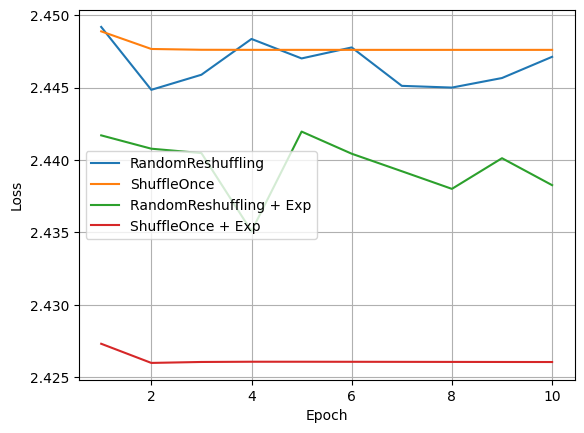

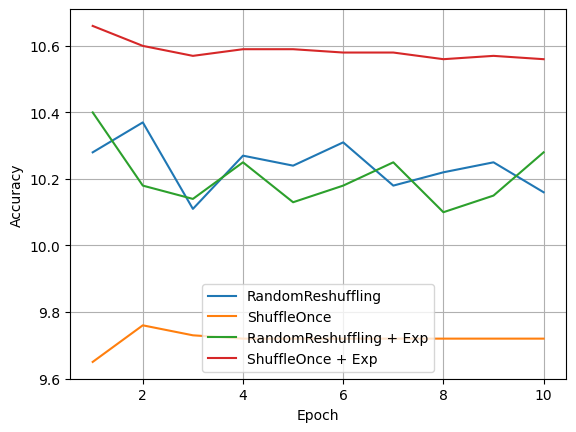

In [ ]:
# Ваше решение (Code)
def plot_curves(title, key, series):
    for label, m in series:
        ep = range(1, len(m[key]) + 1)
        plt.plot(ep, m[key], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy' if 'acc' in key else 'Loss')
    plt.grid()
    plt.legend()
    plt.show()

# Loss
plot_curves('', 'test_loss', [
    ('RandomReshuffling', shuffin1_res),
    ('ShuffleOnce', shuffin2_res),
    ('RandomReshuffling + Exp', metrics_rr_exp),
    ('ShuffleOnce + Exp', metrics_so_exp),
])

# Accuracy
plot_curves('', 'test_acc', [
    ('RandomReshuffling', shuffin1_res),
    ('ShuffleOnce', shuffin2_res),
    ('RandomReshuffling + Exp', metrics_rr_exp),
    ('ShuffleOnce + Exp', metrics_so_exp),
])

Дает ли данная техника улучшение?

In [ ]:
# Ваше решение (Markdown)

**Ответ:**
ShuffleOnce + ExponentialLR дало улучшение, также RandomReshuffing + ExponentialLR дало улучшение по Лоссу